## Stacking the Best Models
<pre><b>This Kernel shows how the scores can be improved using Stacking Method.
Credit Goes to the following kernels
ref:
1. https://www.kaggle.com/filemide/distance-criskiev-hyparam-cont-1-662
2. https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481
3. https://www.kaggle.com/marcelotamashiro/lgb-public-kernels-plus-more-features
4. https://www.kaggle.com/scaomath/no-memory-reduction-workflow-for-each-type-lb-1-28
5. https://www.kaggle.com/fnands/1-mpnn/output?scriptVersionId=18233432
6. https://www.kaggle.com/harshit92/fork-from-kernel-1-481
7. https://www.kaggle.com/xwxw2929/keras-neural-net-and-distance-features
8. https://www.kaggle.com/marcogorelli/criskiev-s-distances-more-estimators-groupkfold?scriptVersionId=18843561
9. https://www.kaggle.com/toshik/schnet-starter-kit
10.https://www.kaggle.com/abazdyrev/nn-w-o-skew

</b></pre>

## Stat Stack

In [13]:
nb = '99-02'

In [14]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
import seaborn as sns
%matplotlib inline
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

champs-scalar-coupling



In [27]:
sub_path = './../output'
all_files = [
'nb60_submission_lgb_-1.5330660525700779.csv',
'nb79_submission_extra_trees_regressor_-1.56760.csv',
# 'nb80_submission_extra_trees_regressor_-1.48000.csv',
# 'nb81_submission_bagging_regressor_-1.44452.csv',
'nb84_submission_extra_trees_regressor_-1.60943.csv',
# 'nb85_submission_extra_trees_regressor_-1.52972.csv',
'nb88_submission_lgb_-1.547953965914086.csv',
# 'nb91_submission_extra_trees_regressor_-1.47467.csv',
'nb91_stack_submission_lgb_-1.7348780297791941.csv',
'nb95_stack_submission_ridge_-1.74195.csv',
'nb95_stack_submission_lasso_-1.74192.csv',
'nb96_stack_submission_extra_trees_regressor_-1.79030.csv',
'nb99_stack_submission_random_forest_regressor_-1.78717.csv',
'nb99-01_stack_submission_lgb_-1.75427.csv',
]

In [28]:
import warnings
warnings.filterwarnings("ignore")
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "mol" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()
ncol = concat_sub.shape[1]

In [29]:
# check correlation
concat_sub.iloc[:,1:].corr()

,mol0,mol1,mol2,mol3,mol4,mol5,mol6,mol7,mol8,mol9
mol0,1.000000,0.999896,0.999903,0.999989,0.999893,0.999989,0.999989,0.999985,0.999984,0.999887
mol1,0.999896,1.000000,0.999982,0.999904,0.999849,0.999941,0.999941,0.999937,0.999934,0.999840
mol2,0.999903,0.999982,1.000000,0.999911,0.999856,0.999951,0.999950,0.999945,0.999942,0.999847
mol3,0.999989,0.999904,0.999911,1.000000,0.999894,0.999989,0.999989,0.999985,0.999984,0.999888
mol4,0.999893,0.999849,0.999856,0.999894,1.000000,0.999903,0.999903,0.999904,0.999903,0.999983
mol5,0.999989,0.999941,0.999951,0.999989,0.999903,1.000000,1.000000,0.999994,0.999993,0.999897
mol6,0.999989,0.999941,0.999950,0.999989,0.999903,1.000000,1.000000,0.999994,0.999993,0.999897
mol7,0.999985,0.999937,0.999945,0.999985,0.999904,0.999994,0.999994,1.000000,0.999998,0.999898
mol8,0.999984,0.999934,0.999942,0.999984,0.999903,0.999993,0.999993,0.999998,1.000000,0.999897
mol9,0.999887,0.999840,0.999847,0.999888,0.999983,0.999897,0.999897,0.999898,0.999897,1.000000


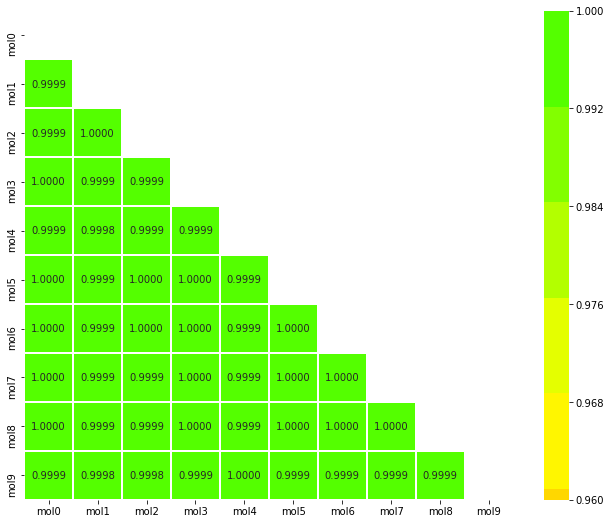

In [30]:
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='prism', vmin=0.96, center=0, square=True, linewidths=1, annot=True, fmt='.4f')

In [31]:
# get the data fields ready for stacking
concat_sub['m_max'] = concat_sub.iloc[:, 1:].max(axis=1)
concat_sub['m_min'] = concat_sub.iloc[:, 1:].min(axis=1)
concat_sub['m_median'] = concat_sub.iloc[:, 1:].median(axis=1)

In [32]:
concat_sub.describe()

,id,mol0,mol1,mol2,mol3,mol4,mol5,mol6,mol7,mol8,mol9,m_max,m_min,m_median
count,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06
mean,5.910918e+06,1.588523e+01,1.588919e+01,1.588932e+01,1.588508e+01,1.588641e+01,1.588586e+01,1.588610e+01,1.588693e+01,1.588691e+01,1.588677e+01,1.607214e+01,1.570292e+01,1.588691e+01
std,7.232878e+05,3.486669e+01,3.485335e+01,3.485485e+01,3.486642e+01,3.486247e+01,3.486702e+01,3.486738e+01,3.486620e+01,3.486627e+01,3.486281e+01,3.499159e+01,3.472687e+01,3.486604e+01
min,4.658147e+06,-3.310883e+01,-3.366021e+01,-3.402612e+01,-3.274398e+01,-2.133904e+01,-3.404520e+01,-3.401845e+01,-3.555385e+01,-3.468478e+01,-2.145506e+01,-2.133750e+01,-3.555385e+01,-3.383933e+01
25%,5.284532e+06,-2.395574e-01,-2.085763e-01,-2.100446e-01,-2.395074e-01,-2.399695e-01,-2.433566e-01,-2.432339e-01,-2.395595e-01,-2.397829e-01,-2.404052e-01,-1.387533e-01,-3.179051e-01,-2.365878e-01
50%,5.910918e+06,2.279640e+00,2.279773e+00,2.279780e+00,2.278372e+00,2.284256e+00,2.270687e+00,2.270837e+00,2.284073e+00,2.284591e+00,2.283506e+00,2.393907e+00,2.162507e+00,2.281261e+00
75%,6.537303e+06,7.363128e+00,7.324036e+00,7.324989e+00,7.362415e+00,7.361783e+00,7.371257e+00,7.371546e+00,7.358291e+00,7.357825e+00,7.366622e+00,7.532041e+00,7.156341e+00,7.358917e+00
max,7.163688e+06,2.037206e+02,2.031305e+02,2.036876e+02,2.085077e+02,1.989875e+02,2.039126e+02,2.039157e+02,2.037053e+02,2.037652e+02,2.016330e+02,2.085077e+02,1.989875e+02,2.036964e+02


In [33]:
cutoff_lo = 0.8
cutoff_hi = 0.2

# Mean Stacking

In [34]:
rank = np.tril(concat_sub.iloc[:,1:ncol].corr().values,-1)
m_gmean = 0
n = 8
while rank.max()>0:
    mx = np.unravel_index(rank.argmax(), rank.shape)
    m_gmean += n*(np.log(concat_sub.iloc[:, mx[0]+1]) + np.log(concat_sub.iloc[:, mx[1]+1]))/2
    rank[mx] = 0
    n += 1

In [35]:
concat_sub['m_mean'] = np.exp(m_gmean/(n-1)**2)

# Median Stacking

In [36]:
path_submission = f'../output/nb{nb}_stack_median_submission.csv'
print(f'save pash: {path_submission}')

concat_sub['scalar_coupling_constant'] = concat_sub['m_median']
concat_sub[['id', 'scalar_coupling_constant']].to_csv(path_submission, 
                                        index=False, float_format='%.6f')

save pash: ../output/nb99-02_stack_median_submission.csv


In [37]:
df = pd.read_csv(path_submission)
df.head()

,id,scalar_coupling_constant
0,4658147,11.982352
1,4658148,184.236777
2,4658149,11.880013
3,4658150,178.853054
4,4658151,12.007548


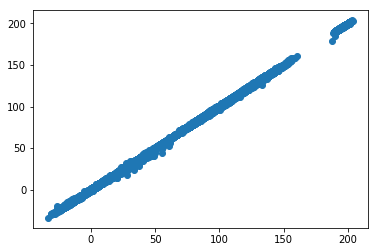

In [38]:
plt.scatter(outs[0].scalar_coupling_constant.values, df.scalar_coupling_constant.values)

# Pushout + Median Stacking
>* Pushout strategy is bit aggresive

# MinMax + Mean Stacking
>* MinMax seems more gentle and it outperforms the previous one

# MinMax + Median Stacking

## Averaging Ranks

Best Results : Stack Median

# Blending Approach